In [1]:
%load_ext autoreload
# %load_ext autoreload
%autoreload 2
import pickle
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt 
import matplotlib as mpl 
from matplotlib import cm

from mpl_toolkits.axes_grid1 import  AxesGrid


from numpy.linalg import norm
from numpy import cos,sin,deg2rad

from scipy.spatial.distance import squareform,pdist
from scipy.io import loadmat


from sklearn.manifold import MDS
from sklearn import linear_model

from scipy.stats import zscore, kendalltau, kruskal, ttest_ind, mannwhitneyu, wilcoxon

import mat73

from matplotlib.colors import LinearSegmentedColormap

plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['pdf.use14corefonts'] = True

# neural geometry


In [3]:
n_con=14
n_mon=8
fig_id=1
axlims=0.5
items_per_dim=n_con*n_mon
col1='lightcoral' 
col2='#5fa8d3'

ii_half = 112

In [4]:
ROIs=['BA6-SMA','BA9-dlPFC','BA13-insula','BA24-dACC',
        'BA28-hip1','BA34-hip','lTPJ','BA23-PCC','OFC']
randstate=[30,30,30,30,]

In [5]:

def plot_MDS_embeddings_2D(xyz,roiname):
    

    %matplotlib inline

    mm = 1/25.4
    fig = plt.figure(1,figsize=(100*mm, 50*mm), dpi=300, facecolor='w', edgecolor='k')
    fig.suptitle("%s"%roiname, fontsize=15)
    plt.subplot(1,2,1)  
    plot_grid2(xyz[0:ii_half,[0,1]],line_width=.5,line_colour=col1,fig_id=fig_id,n_con=n_con,n_mon=n_mon,axlims=axlims)
    scatter_mds_2(xyz[0:ii_half,[0,1]],fig_id=fig_id,task_id='islie',items_per_dim=n_con*n_mon)
    plot_grid2(xyz[ii_half:,[0,1]],line_width=.5,line_colour=col2,fig_id=fig_id,n_con=n_con,n_mon=n_mon,axlims=axlims)
    scatter_mds_2(xyz[ii_half:,[0,1]],fig_id=fig_id,task_id='hon',items_per_dim=n_con*n_mon)
    ax = plt.gca()
    ax.set_xlim([-axlims,axlims])
    ax.set_ylim([-axlims,axlims])    
    ax.xaxis.set_ticks([])
    ax.yaxis.set_ticks([])
    plt.xlabel('dim 1',fontsize=6)
    plt.ylabel('dim 2',fontsize=6)
    ax = plt.gca()
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set_aspect('equal', 'box')

    plt.subplot(1,2,2)
    plot_grid2(xyz[0:ii_half,[1,2]],line_width=.5,line_colour=col1,fig_id=fig_id,n_con=n_con,n_mon=n_mon,axlims=axlims)
    scatter_mds_2(xyz[0:ii_half,[1,2]],fig_id=fig_id,task_id='islie',items_per_dim=n_con*n_mon)
    plot_grid2(xyz[ii_half:,[1,2]],line_width=.5,line_colour=col2,fig_id=fig_id,n_con=n_con,n_mon=n_mon,axlims=axlims)
    scatter_mds_2(xyz[ii_half:,[1,2]],fig_id=fig_id,task_id='hon',items_per_dim=n_con*n_mon)
    ax = plt.gca()
    ax.set_xlim([-axlims,axlims])
    ax.set_ylim([-axlims,axlims])
    ax.xaxis.set_ticks([])
    ax.yaxis.set_ticks([])
    plt.xlabel('dim 2',fontsize=6)
    plt.ylabel('dim 3',fontsize=6)
    ax = plt.gca()
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set_aspect('equal', 'box')
    plt.savefig('/Users/orlacamus/Downloads/mdsplot-%s.png'%roiname)



def param_rdm_model(theta,c,m,islie):
    '''
    generates model rdm from free parameters for 
    compression (rel & irrel dimensions), offset & rotation
    '''
    # unpack parameters 
    c_lie_con,c_lie_mon,c_hon_con,c_hon_mon,a2,ctx = theta
    a1 = 0

    con_new=np.copy(c)
    mon_new=np.copy(m)
    islie_new=np.copy(islie)

    for i in range(len(islie)):

        if islie[i]==1:
            
            con_new[i]=np.array([(1 - c_lie_con) * c[i], (1 - c_lie_mon) * m[i]]) @ np.array([cos(deg2rad(a1)),-sin(deg2rad(a1))]);
            mon_new[i]=np.array([(1 - c_lie_con) * c[i], (1 - c_lie_mon) * m[i]]) @ np.array([sin(deg2rad(a1)),cos(deg2rad(a1))]);
            islie_new[i]=ctx;

        
        if islie[i]==0:
            con_new[i]=np.array([(1 - c_hon_con) * c[i], (1 - c_hon_mon) * m[i]]) @ np.array([cos(deg2rad(a2)),-sin(deg2rad(a2))]);
            mon_new[i]=np.array([(1 - c_hon_con) * c[i], (1 - c_hon_mon) * m[i]]) @ np.array([sin(deg2rad(a2)),cos(deg2rad(a2))]);
        
            

    
    response_vect = pd.DataFrame(np.vstack([con_new,mon_new,islie_new]).T)
    rdm = squareform(pdist(response_vect,'euclidean'))

    
    # vectorise and scale rdm 
    rvect = rdm[np.triu_indices(len(islie_new),k=1)].flatten()
    rvect /= np.max(rvect)
    return rvect


def plot_grid2(xy,line_colour='green',line_width=1,fig_id=fig_id,n_con=n_con,n_mon=n_mon,axlims=axlims):
   
    # %matplotlib qt    
    y,x = np.meshgrid(np.arange(0,n_mon),np.arange(0,n_con))
    x = x.flatten()
    y = y.flatten()    
    try: xy 
    except NameError: xy = np.stack((x,y),axis=1)
    bl = np.stack((x,y),axis=1)
    fig = plt.figure(fig_id)
    
    for ii in range(0,n_con-1):
        for jj in range(0,n_mon-1):
            p1 = xy[(bl[:,0]==ii) & (bl[:,1]==jj),:].ravel()
            p2 = xy[(bl[:,0]==ii+1) & (bl[:,1]==jj),:].ravel()        
            plt.plot([p1[0],p2[0]],[p1[1],p2[1]],linewidth=line_width,color=line_colour)
            p2 = xy[(bl[:,0]==ii) & (bl[:,1]==jj+1),:].ravel()
            plt.plot([p1[0],p2[0]],[p1[1],p2[1]],linewidth=line_width,color=line_colour)
    ii = n_con-1
    for jj in range(0,n_mon-1):
        p1 = xy[(bl[:,0]==ii) & (bl[:,1]==jj),:].ravel()
        p2 = xy[(bl[:,0]==ii) & (bl[:,1]==jj+1),:].ravel()
        plt.plot([p1[0],p2[0]],[p1[1],p2[1]],linewidth=line_width,color=line_colour)

    jj = n_mon-1
    for ii in range(0,n_con-1):
        p1 = xy[(bl[:,0]==ii) & (bl[:,1]==jj),:].ravel()
        p2 = xy[(bl[:,0]==ii+1) & (bl[:,1]==jj),:].ravel()
        plt.plot([p1[0],p2[0]],[p1[1],p2[1]],linewidth=line_width,color=line_colour)
    ax = plt.gca()
    # ax.axes.xaxis.set_ticklabels([])
    # ax.axes.yaxis.set_ticklabels([])  
    ax.set_xlim([-axlims,axlims])
    ax.set_ylim([-axlims,axlims])


def scatter_mds_2(xyz,task_id='islie',fig_id=fig_id,items_per_dim=items_per_dim,marker_scale=1):
    

    #col1 = (0, 0, .55)
    #col2 = (201/255,52/255,44/255)
    col1='lightcoral' 
    col2='#5fa8d3'
    
    n_items=items_per_dim
    
    if task_id=='both':
        n_items = items_per_dim*2
        ctxMarkerEdgeCol = [col1,col2]
    elif task_id=='islie':
        n_items = items_per_dim
        ctxMarkerEdgeCol = col1
    elif task_id=='hon':
        n_items = items_per_dim
        ctxMarkerEdgeCol = col2
    

    ctxMarkerCol = 'white'
    ctxMarkerSize = 4*marker_scale
    itemMarkerSize = 1
  
    #scat_consis = np.array([[63,39,24], [64,82,21], [65,125,18], [66,168,15], [68,255, 10], [63,39,24], [64,82,21], [65,125,18], [66,168,15], [68,255, 10], [63,39,24], [64,82,21], [65,125,18], [66,168,15]])/255
    scat_consis=np.array(['#ffff3f','#ffea00','#ffdd00','#ffd000','#ffba08','#faa307','#f48c06','#e85d04','#dc2f02','#d00000','#9d0208','#6a040f','#6a040f','#370617','#03071e'])
    scat_money = np.linspace(.5,2.5,8)*marker_scale
   
    
    
    indm,indc = np.meshgrid(np.arange(0,8),np.arange(0,14))

    indc = indc.flatten()
    indm = indm.flatten()   
    x = xyz[:,0]
    y = xyz[:,1]

   
    for ii in range(0,n_items):
        
        plt.plot(x[ii],y[ii],marker='o',markerfacecolor=ctxMarkerCol,markeredgecolor=ctxMarkerEdgeCol,markersize=ctxMarkerSize,markeredgewidth=.5)
        plt.plot(x[ii],y[ii],marker='o',markeredgecolor=scat_consis[indc[ii]],markerfacecolor=scat_consis[indc[ii]],markersize=scat_money[indm[ii]])


    
    

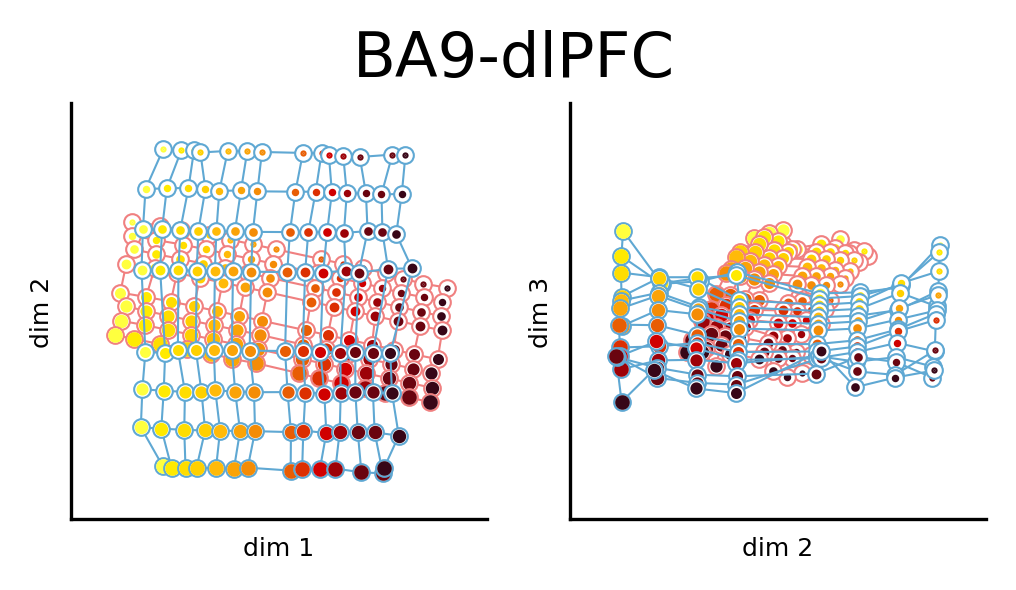

In [5]:
roiname='BA9-dlPFC'
data = mat73.loadmat('results/meanParams_%s.mat'%roiname)
param=data['param']
[c,islie,m]=np.meshgrid([-7,-6,-5,-4,-3,-2,-1,1,2,3,4,5,6,7],[1,0],[-8,-6,-4,-2,2,4,6,8])
#[c,m,islie]=np.meshgrid([-7,-6,-5,-4,-3,-2,-1,1,2,3,4,5,6,7],[-8,-6,-4,-2,2,4,6,8],[1,0])
c=c.ravel()*1.0
m=m.ravel()*1.0
islie=islie.ravel()*1.0
rdm=squareform(param_rdm_model(param,c,m,islie))
xyz = MDS(n_components=3,dissimilarity='precomputed',max_iter=10000,metric=True,random_state=29)
xyz = xyz.fit_transform(rdm)


#xyz = MDS(n_components=3,dissimilarity='euclidean',max_iter=10000)
#xyz = xyz.fit_transform(compr_data(param,c,m,islie).T)

plot_MDS_embeddings_2D(xyz,roiname)

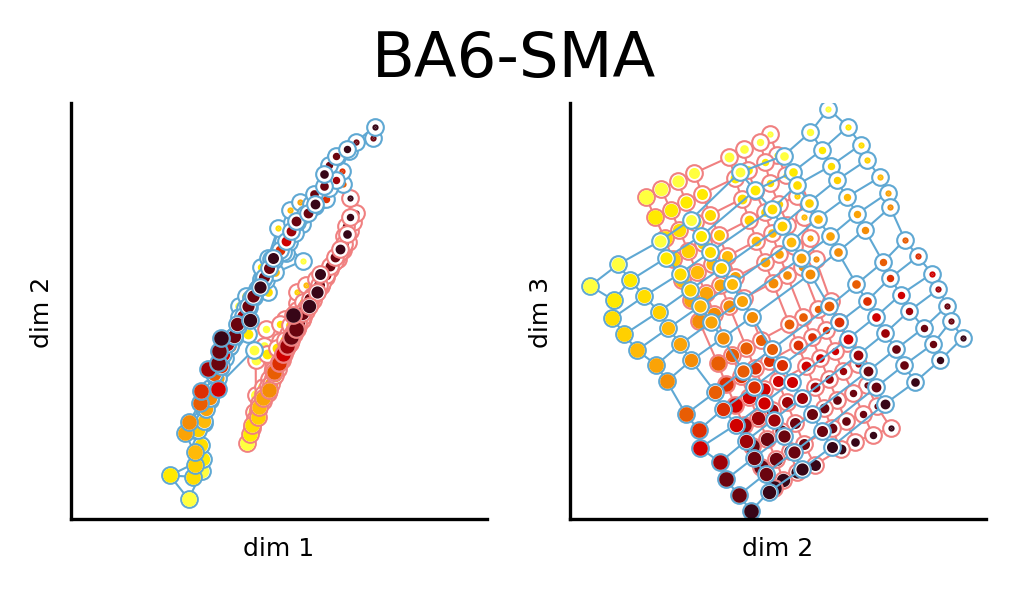

In [8]:
roiname='BA6-SMA'
data = mat73.loadmat('results/meanParams_%s.mat'%roiname)
param=data['param']
[c,islie,m]=np.meshgrid([-7,-6,-5,-4,-3,-2,-1,1,2,3,4,5,6,7],[1,0],[-8,-6,-4,-2,2,4,6,8])
#[c,m,islie]=np.meshgrid([-7,-6,-5,-4,-3,-2,-1,1,2,3,4,5,6,7],[-8,-6,-4,-2,2,4,6,8],[1,0])
c=c.ravel()*1.0
m=m.ravel()*1.0
islie=islie.ravel()*1.0
rdm=squareform(param_rdm_model(param,c,m,islie))
xyz = MDS(n_components=3,dissimilarity='precomputed',max_iter=10000,metric=True,random_state=3)
xyz = xyz.fit_transform(rdm)


#xyz = MDS(n_components=3,dissimilarity='euclidean',max_iter=10000)
#xyz = xyz.fit_transform(compr_data(param,c,m,islie).T)

plot_MDS_embeddings_2D(xyz,roiname)

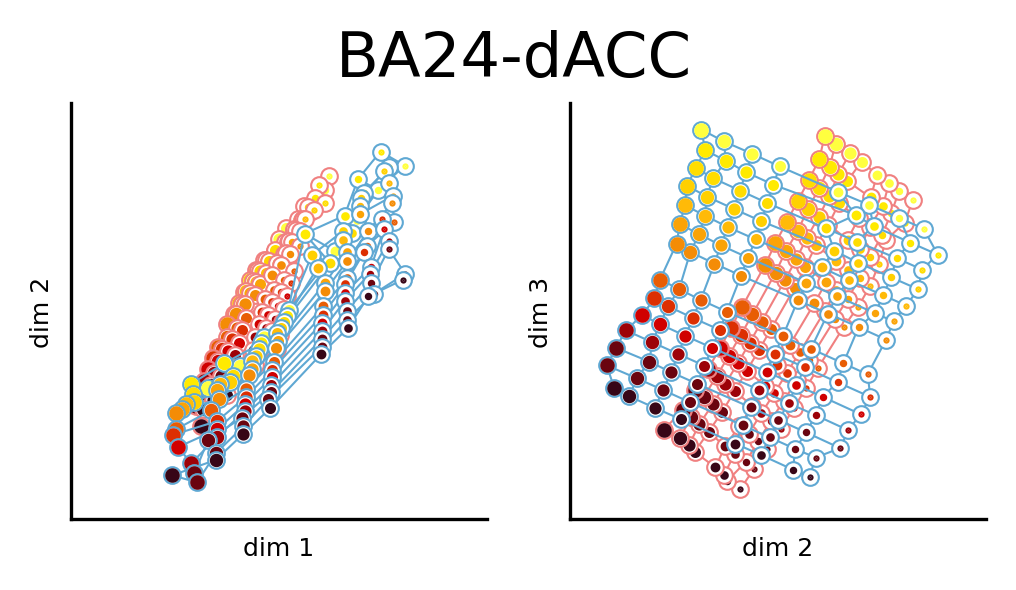

In [9]:
roiname='BA24-dACC'
data = mat73.loadmat('results/meanParams_%s.mat'%roiname)
param=data['param']
[c,islie,m]=np.meshgrid([-7,-6,-5,-4,-3,-2,-1,1,2,3,4,5,6,7],[1,0],[-8,-6,-4,-2,2,4,6,8])
#[c,m,islie]=np.meshgrid([-7,-6,-5,-4,-3,-2,-1,1,2,3,4,5,6,7],[-8,-6,-4,-2,2,4,6,8],[1,0])
c=c.ravel()*1.0
m=m.ravel()*1.0
islie=islie.ravel()*1.0
rdm=squareform(param_rdm_model(param,c,m,islie))
xyz = MDS(n_components=3,dissimilarity='precomputed',max_iter=10000,metric=True,random_state=29)
xyz = xyz.fit_transform(rdm)


#xyz = MDS(n_components=3,dissimilarity='euclidean',max_iter=10000)
#xyz = xyz.fit_transform(compr_data(param,c,m,islie).T)

plot_MDS_embeddings_2D(xyz,roiname)

In [12]:
param

array([ 0.5529295 ,  0.84326887,  0.62798181,  0.6044159 , -9.36533754,
        0.99460716])

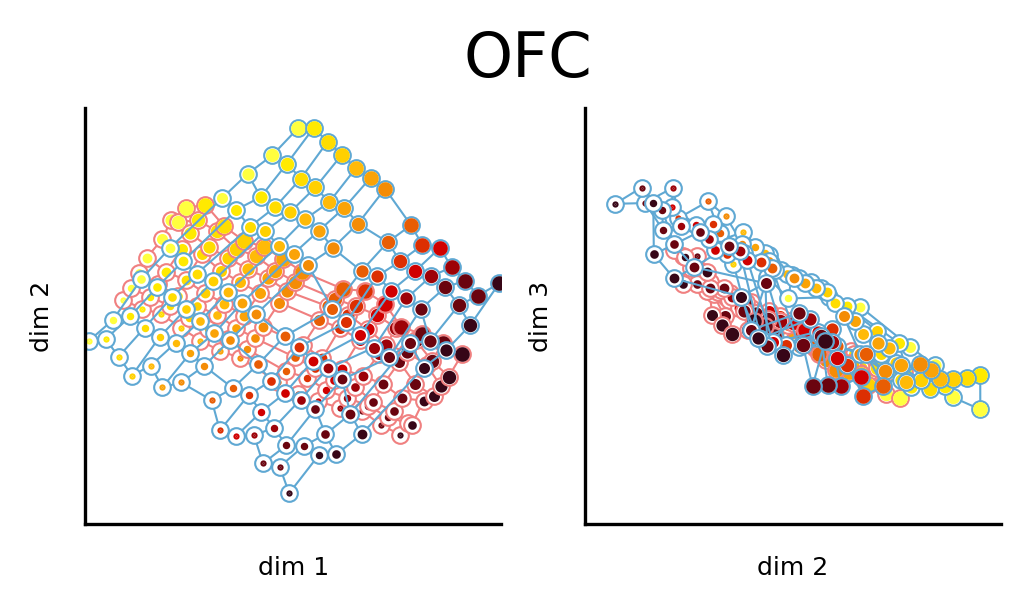

In [11]:
roiname='OFC'
data = mat73.loadmat('results_seuc/meanParams_%s.mat'%roiname)
param=data['param']
[c,islie,m]=np.meshgrid([-7,-6,-5,-4,-3,-2,-1,1,2,3,4,5,6,7],[1,0],[-8,-6,-4,-2,2,4,6,8])
#[c,m,islie]=np.meshgrid([-7,-6,-5,-4,-3,-2,-1,1,2,3,4,5,6,7],[-8,-6,-4,-2,2,4,6,8],[1,0])
c=c.ravel()*1.0
m=m.ravel()*1.0
islie=islie.ravel()*1.0
rdm=squareform(param_rdm_model(param,c,m,islie))
xyz = MDS(n_components=3,dissimilarity='precomputed',max_iter=10000,metric=True,random_state=2)
xyz = xyz.fit_transform(rdm)


#xyz = MDS(n_components=3,dissimilarity='euclidean',max_iter=10000)
#xyz = xyz.fit_transform(compr_data(param,c,m,islie).T)

plot_MDS_embeddings_2D(xyz,roiname)

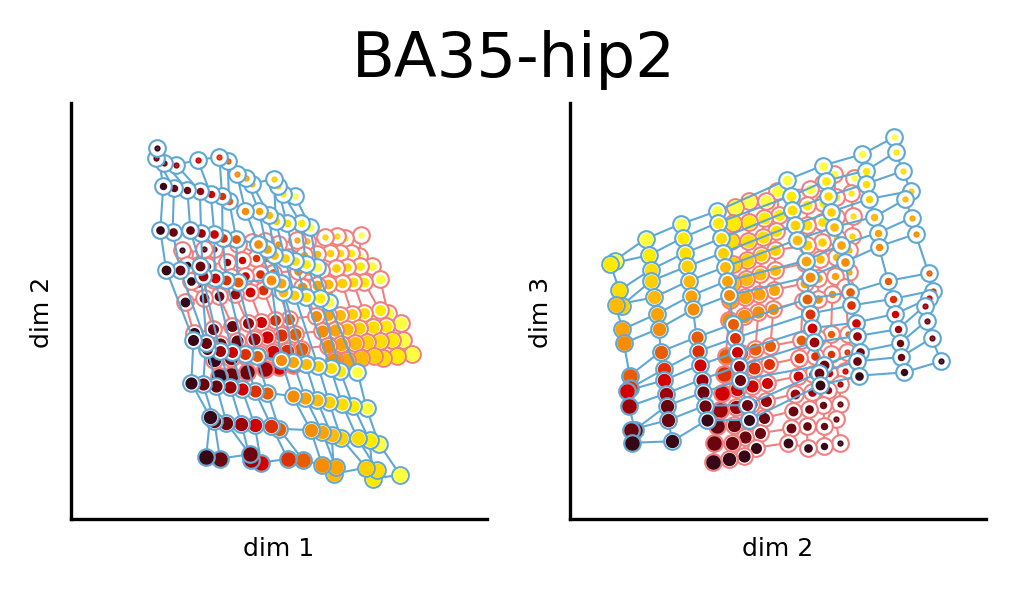

In [211]:
roiname='BA35-hip2'
data = mat73.loadmat('results/meanParams_%s.mat'%roiname)
param=data['param']
[c,islie,m]=np.meshgrid([-7,-6,-5,-4,-3,-2,-1,1,2,3,4,5,6,7],[1,0],[-8,-6,-4,-2,2,4,6,8])
#[c,m,islie]=np.meshgrid([-7,-6,-5,-4,-3,-2,-1,1,2,3,4,5,6,7],[-8,-6,-4,-2,2,4,6,8],[1,0])
c=c.ravel()*1.0
m=m.ravel()*1.0
islie=islie.ravel()*1.0
rdm=squareform(param_rdm_model(param,c,m,islie))
xyz = MDS(n_components=3,dissimilarity='precomputed',max_iter=10000,metric=True,random_state=30)
xyz = xyz.fit_transform(rdm)


#xyz = MDS(n_components=3,dissimilarity='euclidean',max_iter=10000)
#xyz = xyz.fit_transform(compr_data(param,c,m,islie).T)

plot_MDS_embeddings_2D(xyz,roiname)

In [ ]:
for r in range(len(ROIs)):
    roiname=ROIs[r]
    data = mat73.loadmat('results/meanParams_%s.mat'%roiname)
    param=data['param']
    [c,islie,m]=np.meshgrid([-7,-6,-5,-4,-3,-2,-1,1,2,3,4,5,6,7],[1,0],[-8,-6,-4,-2,2,4,6,8])
    #[c,m,islie]=np.meshgrid([-7,-6,-5,-4,-3,-2,-1,1,2,3,4,5,6,7],[-8,-6,-4,-2,2,4,6,8],[1,0])
    c=c.ravel()*1.0
    m=m.ravel()*1.0
    islie=islie.ravel()*1.0
    rdm=squareform(param_rdm_model(param,c,m,islie))
    xyz = MDS(n_components=3,dissimilarity='precomputed',max_iter=10000,metric=True)
    xyz = xyz.fit_transform(rdm)


    #xyz = MDS(n_components=3,dissimilarity='euclidean',max_iter=10000)
    #xyz = xyz.fit_transform(compr_data(param,c,m,islie).T)

    plot_MDS_embeddings_2D(xyz,roiname)

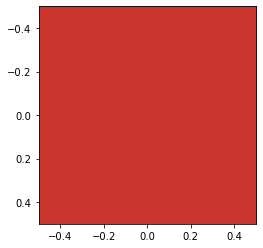

In [819]:
plt.imshow([[(201,52,44)]])